# Problema: Information Retrieval
Text retrieval é uma tarefa em que o sistema responderá à query do usuario com documentos *relevantes*. A colecao de documentos relevantes é uma funçao da query $R(q)$ e é dependente do usuario. Portanto, vou encontar $R'(q)$, uma estimativa dos documentos relevantes - para encontar essa funcao, farei ranking onde a funcao $f(q,d)\in  \mathcal{R}$ é uma funcao de medida de relevancia. Existem varios algoritmos diferentes para computar $f(q,d)$. Dentre eles:

* ## Similarity based models:
Assumimos que se um documento é mais similar à query do que outro documento, entao o primeiro documento sera considerado mais relevante dp que o segundo - **vector space models**

* ## Modelos probabilisticos:
Assumimos que queries e docs sao observacoes de variaveis aleatorias. Assumimos que existe uma variavel binaria $R \{0,1\}$ que indica se o documento é relevante ou nao. O **score do documento** é entao definido como a **probabilidade** da variavel aleatoria $R$ ser igual a 1.

* ## Latent Semantic Indexing

Several statistical and AI techniques have been used in association with domain semantics to extend the vector space model to help overcome some of the retrieval problems described above, such as the "dependence problem" or the "vocabulary problem". One such method is Latent Semantic Indexing (LSI). In LSI the associations among terms and documents are calculated and exploited in the retrieval process. The assumption is that there is some "latent" structure in the pattern of word usage across documents and that statistical techniques can be used to estimate this latent structure. An advantage of this approach is that queries can retrieve documents even if they have no words in common. The LSI technique captures deeper associative structure than simple term-to-term correlations and is completely automatic. The only difference between LSI and vector space methods is that LSI represents terms and documents in a reduced dimensional space of the derived indexing dimensions. As with the vector space method, differential term weighting and relevance feedback can improve LSI performance substantially.

[M. Pannu et. al, 2014 A Comparison of Information Retrieval Models](https://www.researchgate.net/publication/265913721_A_Comparison_of_Information_Retrieval_Models)



Esses modelos sao todos baseados que usamos "bag of words" para representar o texto. Portanto, o score so doc dependera do score de cada palavra individual. O score das palavras é determinado pela frequencia com a qual elas aparecem no documento. Assim, dando match com um termo raro na colecao de palavras vai contribuir mais para o score total do que dar match com um termo comum.



***
***
# Sumário

* # 1. [Análise exploratória](#analise_expl)
    * ## 1.1. [Entendendo os dados](#analise_expl)
    * ## 1.2. [Pré-preocessamento: limpar e preparar dados](#limpar_preparar)
    * ## 1.   [Vetorizar query e features de produtos usando TF-IDF](#TF-IDF)

Analise do numero de cliques e vendas para as palavras mais frequentes

    * ## 1.?. [Análise de Frequencia](#analise_freq)
    
 Quais sao as palavras mais comuns? Quais sao as palavras mais comuns por par query-product?
 - construcao de sinonimos: sempre que alguem buscar por 'lembrancinha' eu busque tambem por 'natal', por exemplo
<br>


* # 2. [Construção do Índice](#construcao_ind)
Armazenar texto de forma mais inteligente.  Ele vai separar o texto inserido em algo pesquisavel, como grafemas, separar preposicoes dos artigos. 
Quando criamos um indice, sempre que inserimos uma nova linha no banco de dados, ele ja faz algumas operacoes para otimizar a busca naquele campo.
Esse indice pode estar em varias colunas diferentes. Assim, quando for buscar uma palavra, o codigo vai nas colunas para procura-las


We saw in Boolean Retrieval of Term Document Matrix that size of it grows very quickly and occupying a large amount of memory and it could be a bad mechanism for searching purpose. And the matrix is storing more than 99% of the storage to just denote a particular term doesn't occur in a document (sparse matrix).

For understanding the concept of Inverted Index lets consider the same corpus as of Term Document Matrix and to tokenize the terms of the document.


Keyword Search Vs Semantic Search
At first, search engines were lexical: the search engine looked for literal matches of the query words, without understanding of the query’s meaning and only returning links that contained the exact query.By using regular keyword search, a document either contains the given word or not, and there is no middle ground

On the other hand, "Semantic Search" can simplify query building, becuase it is supported by automated natural language processing programs i.e. using Latent Semantic Indexing - a concept that search engines use to discover how a keyword and content work together to mean the same thin
<br>


* # 3. [Ranking](#ranking)
Depois de criar o indice, temos que utiliza-lo. Podemos construir um modelo, que procure match entre as palavras da query e as palavras das colunas textuais (que foram indexadas). E depois trazer os resultados ordenados por relevancia

<br>


* # 4. [Análise dos resultados](#analise_result)


***
***

In [1]:
#importar bibliotecas

import numpy as np
import matplotlib.pyplot as plt
#frequency cloud plot
from wordcloud import WordCloud

import seaborn as sns
import pandas as pd

plt.style.use('ggplot')

#processamento de linguagem natural
#tokenizacao, lemmatizacao em portugues

import spacy
#chamar modelo em portugues
nlp = spacy.load("pt_core_news_sm")

import re
import string
import nltk
#regular expressions biblioteca para detectar padroes em texto


2023-02-04 17:21:23.296931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id='analise_expl'></a>
#  1. Análise exploratória

Nesse estagio, vou me familiarizar com os dados para criar intuição sobre o problema e assim, ser capaz de começar a formular hipóteses testáveis.

## Carregando dados

In [2]:
pd.set_option('display.max_colwidth', None)

df_pairs = pd.read_csv("../dados/pairs.csv")#, delimiter=";")
df_products = pd.read_csv("../dados/products.csv")#, delimiter=";")

# 1.1. Entendendo os dados
Vamos olhar para as caracteristicas basicas do banco de dados
* Dataframe shape
* head and tail
* dtypes

Vamos começar vendo o que tem dentro de cada dataframe

In [3]:
# features da relação entre o par query e produto
print(df_pairs.info())
print(df_pairs.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89832 entries, 0 to 89831
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   pair_id            89832 non-null  int64 
 1   product_id         89832 non-null  int64 
 2   query              89832 non-null  object
 3   search_position    89832 non-null  int64 
 4   print_count_query  89832 non-null  int64 
 5   view_count_query   89832 non-null  int64 
 6   cart_count_query   89832 non-null  int64 
 7   order_count_query  89832 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 5.5+ MB
None
(89832, 8)


In [4]:
df_pairs.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,8589934593,14817,Convite Padrinhos Batismo,319,2374,18,1,0
1,8589934636,14884,Decoracao De Casamento,254,388,1,0,0
2,8589934836,8589934668,Toalha De Lavabo,233,219,2,0,0
3,8589934727,17179884005,Calendario 2023 Editavel,40,4871,2,0,0
4,8589934934,25769803777,Ecobag,286,166,3,0,0


Coluna com texto:
* query

In [5]:
print(df_products.info())
print(df_products.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76770 entries, 0 to 76769
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           76770 non-null  int64  
 1   title                76770 non-null  object 
 2   tags                 76770 non-null  object 
 3   creation_date        76770 non-null  object 
 4   price                76770 non-null  float64
 5   weight               76719 non-null  float64
 6   express_delivery     76770 non-null  int64  
 7   category             76762 non-null  object 
 8   minimum_quantity     76770 non-null  int64  
 9   print_count_product  76770 non-null  int64  
 10  view_count_product   76770 non-null  int64  
 11  cart_count_product   76770 non-null  int64  
 12  order_count_product  76770 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 7.6+ MB
None
(76770, 13)


In [6]:
#features de produtos
df_products.head()

,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product
0,101,Jogo Banheiro de Crochê de 3 Peças,"['#jogobanheiro #croche #tapetes', 'decoração', 'nas cores chumbo e rosa bebê']",2022-09-25 13:43:36,110.0,1.0,1,Técnicas de Artesanato,1,11,0,0,0
1,106,Guardanapos de Tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversário']",2014-12-26 18:47:48,269.5,0.0,0,Casa,1,62,6,0,0
2,47,Toalha Papai Noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mão', 'crochê', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,Casa,1,423,4,0,0
3,8589941942,Caixa para 1 bis feliz natal cliente como você sempre quero,"['lembrança', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartão de natal']",2021-11-22 15:02:30,45.0,0.0,0,Lembrancinhas,30,2746,93,6,2
4,17179869192,Árvore de Natal decorada em MDF,"['#madajoartesanato', '#decoraçaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,Decoração,1,1010,4,0,0


colunas de texto
* title
* tags 
* category

# 1.2 Pré-analise - analise "no olho"
Vamos olhar as features do produto mais clicado por query.

Essa analise inicial sera feita manualmente com um numero baixo de queries (20). Queremos detectar a presença de algum tipo de padrao. Aqui, queremos entender mais sobre o problema, respondendo as seguintes perguntas:
* 1. Quais features textuais parecem mais relevantes para o match (title, tags e category)?
* 2. Quais estruturas textuais importam para o match produto query? 
    * é um match de keyword? 
    * é um match semantico?
    
    
A principio, vamos analisar as colunas

* title
* tags
* category
* query



e usar como medida da relevancia de um determinado produto por query os dados de
* view_count_query - número de cliques que o produto recebeu a partir de sua aparição nos resultados da busca para a consulta query
* cart_count_query - número de vezes que o produto foi adicionado ao carrinho a partir de sua aparição nos resultados da busca para a consulta query
* order_count_query - número de vezes que o produto foi comprado a partir de sua aparição nos resultados da busca para a consulta query



## Remover Null values
Vamos examinar se temos algum valor faltante nos dataframes. Dos outputs abaixo, parece que apenas as colunas **weight** e **category** do dataframe **df_products** tem valores faltantes

In [7]:
print("---- df_pairs ----")
for col in df_pairs.columns:
    print(col, df_pairs[col].isnull().sum())
print("\n")


print("---- df_products ----")
for col in df_products.columns:
    print(col, df_products[col].isnull().sum())
print("\n")

---- df_pairs ----
pair_id 0
product_id 0
query 0
search_position 0
print_count_query 0
view_count_query 0
cart_count_query 0
order_count_query 0


---- df_products ----
product_id 0
title 0
tags 0
creation_date 0
price 0
weight 51
express_delivery 0
category 8
minimum_quantity 0
print_count_product 0
view_count_product 0
cart_count_product 0
order_count_product 0




In [8]:
#removendo linhas com valores faltantes
df_products.dropna(inplace=True)
#arrumar indices depois de remover linhas nan
df_products.reset_index(inplace=True)

print("---- df_products ----")
for col in df_products.columns:
    print(col, df_products[col].isnull().sum())
print("\n")

df_products.info()
#removemos 59 linhas

---- df_products ----
index 0
product_id 0
title 0
tags 0
creation_date 0
price 0
weight 0
express_delivery 0
category 0
minimum_quantity 0
print_count_product 0
view_count_product 0
cart_count_product 0
order_count_product 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76711 entries, 0 to 76710
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                76711 non-null  int64  
 1   product_id           76711 non-null  int64  
 2   title                76711 non-null  object 
 3   tags                 76711 non-null  object 
 4   creation_date        76711 non-null  object 
 5   price                76711 non-null  float64
 6   weight               76711 non-null  float64
 7   express_delivery     76711 non-null  int64  
 8   category             76711 non-null  object 
 9   minimum_quantity     76711 non-null  int64  
 10  print_count_product  76711 non-null  int64  
 11  view_cou

In [9]:
df_products['title'][3519]

'Tubolata 7x5 Personalizada Safari'

## Criar dataframe
Vamos criar um dataframe com os produtos mais clidados com as colunas
* title
* tags
* category
* query

* view_count_query 
* cart_count_query 
* order_count_query 
* search_position - número da posição em que o produto apareceu dentro da página de busca (mín 1 e máx 400)
juntando df_pairs e df_products com a chave primaria *product_id*

## Distribuicao do numero de compras pela query

O par produto-query com o maior numero de vendas teve  61  vendas


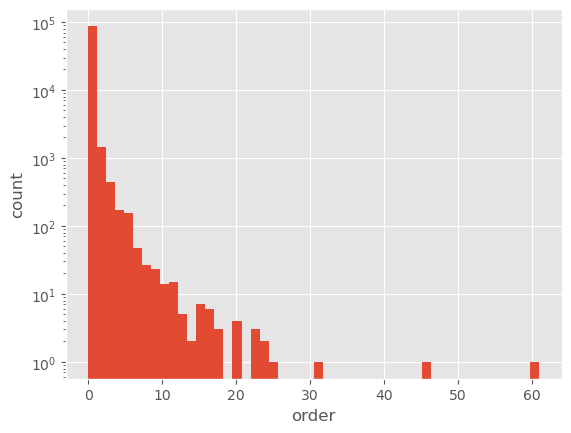

In [10]:
#distribuicao do numero total de compras a partir da aparição dos produtos
#nos resultados da busca para a consulta query

ax = df_pairs['order_count_query'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("order")
ax.set_ylabel("count")


print("O par produto-query com o maior numero de vendas teve ",df_pairs['order_count_query'].max(), " vendas")

In [11]:
n_vendas_par = 13

print("Numero de produtos com mais de", n_vendas_par, "vendas dado uma query é",
      df_pairs[df_pairs['order_count_query'] >= n_vendas_par].count()['product_id'])

Numero de produtos com mais de 13 vendas dado uma query é 36


### pegar features de produto associados a esses pares query-produto

In [12]:
df_popular_par = df_pairs[df_pairs['order_count_query'] >= n_vendas_par]
df_pop_par = df_popular_par.merge(df_products, on="product_id", how="left")
df_pop_par = df_pop_par[['pair_id', 'query', 'product_id', 'title', 'tags', 'category', 'search_position', "order_count_query"\
           ]]

print(df_pop_par.shape)

(36, 8)


In [13]:
#visualizar features, ordenando pelo maior numero de vendas
df_pop_par.sort_values(by=['order_count_query'], ascending=False).head(36)

,pair_id,query,product_id,title,tags,category,search_position,order_count_query
34,377957122385,Lembrancinha De Natal,8513,Sousplat crochê,"['crochê', 'sousplat', 'crochet', 'croche', 'mesa posta', 'suporte pratos', 'decoração mesa', 'jogo americano']",Casa,2,61
33,171798692060,Lembrancinha De Natal,8589934680,Guirlanda em Palha Porta 36cm Decoração de Natal,"['guirlanda', 'guirlanda natal', 'natal', 'porta', 'festão', 'berry', 'glitter', 'laço', 'natalina']",Decoração,9,46
3,1443109011833,Manual Dos Padrinhos,25769815661,Biquíni de Crochê,"['bikini', 'biquíni', 'biquine', 'crochet', 'crochê', 'cortininha', 'cropped', 'ciganinha', 'top', 'crocheperfeito', 'crochetaria', 'fio dental', 'calcinhas', 'praia', 'neon', 'tricot', 'tomara que caia', 'babadinho', 'cavado']",Roupas,1,31
20,103079215473,Lembrancinha De Natal,25769804360,Bloco de anotações personalizado,"['bloco de notas com nome', 'mimo para professores', 'bloco com nome', 'dia dos pais', 'ecológico', 'datas comemorativas', 'presente escola', 'brindes de final de ano', 'rematrícula', 'corpirativo', 'brindes empresas']",Lembrancinhas,3,25
29,790273982769,Porta Guardanapo,17179874020,CHINELO - Formatura Medicina,"['sandalia personalizada', 'brinde formatura', 'chinelo personalizado', 'chinelo formatura', 'medicina', 'sandalias personalizadas', 'chinelo personalizado enfermagem', 'sandalia personalizada medicina', 'formatura de medicina', 'lembrancinha medicina', 'chinelo para formatura', 'chinelo personalizado para formatura', 'chinelos de formatura', 'chinelos formatura', 'chinelos para formatura', 'sandalia de formatura', 'sandalia para festa de formatura', 'sandalia para formatura', 'sandalias de formatura', 'sandalias formatura', 'sandalias para festa de formatura', 'sandalias para festas de formatura', 'sandalias para formatura', 'sandalias para formaturas', 'sandalias personalizadas formatura', 'chinelos medicina', 'sandalias para festa de formatura medicina', 'sandalias personalizadas para formatura medicina', 'sandalias personalizadas formatura medicina', 'sandalias para formatura medicina', 'chinelo personalizado para formatura medicina', 'sandalias de formatura medicina', 'chinelo para formatura medicina', 'chinelos de formatura medicina', 'sandalia para festa de formatura medicina', 'sandalias formatura medicina', 'sandalia para formatura medicina', 'sandalia de formatura medicina', 'sandalias para festas de formatura medicina', 'sandalias para formaturas medicina', 'medicina', 'formando', 'chinelo medicina', 'sandália medicina', 'sandálias medicina', 'formado em medicina', 'lembrancinha medicina', 'lembrancinhas medicina', 'medicina', 'brindes medicina', 'brinde medicina']",Lembrancinhas,1,24
23,816043786323,Suculentas Lembrancinhas,8589949704,Caixa Milk Homem Aranha,"['caixa leite mickey', 'caixa milk mickey', 'caixa mickey', 'festa mickey', '3d', 'homem aranha', 'spider man', 'caixa leite homem aranha', 'caixa tipo milk homem aranha', 'milk', 'leite', 'homem aranha 3d', 'novo homem aranha']",Aniversário e Festas,3,24
35,1194000908673,Lembrancinhas De Casamento,10754,Topo De Bolo Casamento,"['topo de bolo', 'noivos', 'violão']",Aniversário e Festas,1,23
11,1451698946138,Lembrancinha Cha De Revelacao,8589943254,Vela aromática pote patê com tampa personalizada,"['vela', 'velapersonalizada', 'lembrança', 'lembrancinha', 'pote patê', 'vela pote patê', 'vela vidro preto', 'vela tampa madeira', 'maternidade']",Lembrancinhas,1,23
32,85899346198,Copos Para Lembrancinhas,17179884357,Adesivo Marmitinha MARIA CLARA E JP,"['rótulo', 'adesivo', 'lembrancinha', 'festa', 'colante', 'personalizado', 'arte', 'rotulo', 'rótulos', 'rotulos', 'adesivos', 'rotulo adesivo', 'rótulos adesivos', 'rótulo adesivo', 'rotulos adesivos', 'papel colante', 'adesivo multiuso', 'adesivos personalizados', 'papelaria de festa', 'sacola personalizada', 'adesivo tubete personalizado', 'adesivo latinha personalizado', 'adesivo caixinha personalizado', 'festa de aniversário', 'maria clara e jp', 'a

A principio a maior parte dessas queries nao parece ter match imediato (metodos de match keyword com keyword provavelmente nao vao devolver bons resultados) com os titulos e descricoes dos produtos vendidos. As queries e as sao **ambiguas** - nao ha uma semantica bem definida para especificar quais produtos a serem retornados 

Por ex:
query: Lembrancinha de Natal 
title: Sousplat crochê

Alem disso, porque nao parecem haver respostas certas para uma mesma query (a resposta para a query Lembrancinha de Natal pode ser tanto "Sousplat croche" quanto "Guirlanda em Palha") vamos recorrer a uma analise empirica envolvendo as respostas dos usuarios (numero de cliques pos query, numero de vendas pos query) para saber qual metodo funciona melhor. 

## Distribuicao do numero de itens adicionados ao carrinho pela query

O par produto-query com o maior numero de vendas teve  183  vendas


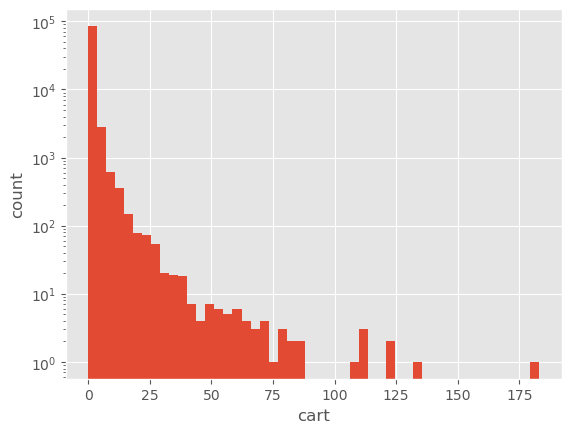

In [14]:
ax = df_pairs['cart_count_query'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("cart")
ax.set_ylabel("count")


print("O par produto-query com o maior numero de vendas teve ",df_pairs['cart_count_query'].max(), " vendas")

## Distribuicao do numero cliques pela query

O par produto-query com o maior numero de vendas teve  4529  vendas


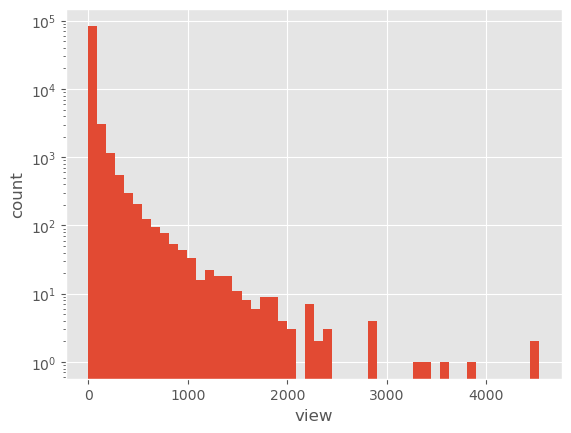

In [15]:
ax = df_pairs['view_count_query'].plot(kind='hist', bins=50, log=True)
ax.set_xlabel("view")
ax.set_ylabel("count")

print("O par produto-query com o maior numero de vendas teve ",df_pairs['view_count_query'].max(), " vendas")

Text(0, 0.5, 'count')

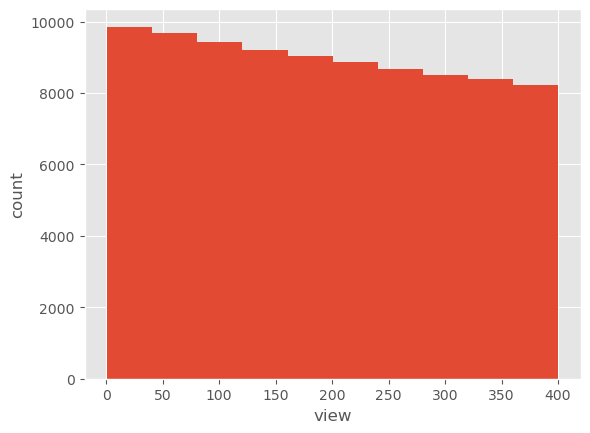

In [16]:
ax = df_pairs['search_position'].plot(kind='hist', bins=10)#, log=True)
ax.set_xlabel("view")
ax.set_ylabel("count")

#print("O par produto-query com o maior numero de vendas teve ",df_pairs['view_count_query'].max(), " vendas")

<a id='limpar_preparar'></a>
#  1.3. Pré-processamento: limpar e preparar dados

Vamos preparar/limpar nossos dados para a análise exploratoria. Para decidir o que fazer nesse estagio, vamos relembrar qual é o nosso problema: queremos criar um modelo que seja capaz de, dada uma query, retornar produtos mais relevantes (baseados nas suas descricoes) e recomendar produtos diferentes.

Portanto, no estagio de limpeza de dados é interessante:
* Que o algoritmo seja capaz de detectar palavras com errors ortograficos como iguais. Ex:
            guardanapos = gurdanapo
            aniversário = aniversario
            
* remover captalizacao, para que o algoritmo nao diferencie, por ex.: guardanapos de Guardanapos

* Queremos remover inflexoes das palavras -> lemmetizacao

* Remover palavras que nao acrescentam signifcado ao texto (stopwords)

* Queremos lidar com ambiguidade à nível de palavras. Por exemplo, uma mesma palavra pode ser um substantivo ou um adjetivo (e.g. rosa)



No fim, queremos fazer o computador entender as queries e descricoes dos produtos, para entao, poder compara-las. Assim, seguiremos as seguintes etapas:

* 1. Remover Null values
* 2. Tokenization 
* 3. Remover pontuações
* 4. Remover stopwords
* 5. Converter todos os caracteres para letras minusculas
* 6. POS
* 7. Lemmatization/Steming
* 8. Word embedding


### Lematization or steming
Dependendo do quão elaborado seja o algoritmo da lemmatization, ele pode gerar associação entre sinônimos tornando essa técnica muito mais rica nos resultados, como relacionar a palavra trânsito e a palavra engarrafamento. Este mesmo resultado não aconteceria na técnica stemming que apenas reduziria essas palavras. Assim, essa técnica não é a ideal em idiomas morfologicamente mais complexos.

Stemming ainda pode gerar dois tipos de problemas como: cortar demais e acabar com um stem que não tem sentido e perdeu muito de sua informação; ou também cortar demais e ter dois stem iguais para palavras com significados muito diferentes. A lemmatization é mais lenta, mas garante que vai gerar palavras gramaticalmente corretas e com maior precisão já que leva a classe gramatical em consideração.

* Stemming é mais comumente usada por mecanismos de busca para indexar palavras.
* Já a lemmatization tem seu uso interessante junto a técnica como vetorização de palavras (word vectors), Tf-idf e LDA para modelagem de tópicos onde, eliminando plurais e utilizando sinônimos, podemos ter um aumento de precisão nessas técnicas

<a id='pontuacao'></a>


## 1.3.2 Normallizar, Remover pontuação e tokenizar

Anteriormente, vimos que as colunas que contem dados em forma de texto sao:
* em df_pair:
    * query
    
* em df_products:
    * title
    * tags 
    * category    

Com os pré-processamentos, queremos reduzir o tamanho do vocabulário e simplificar algumas formas lexicais, garantindo, assim, que o algoritmo obtenha informações relevantes e que de fato representam o nosso os produtos e as queries

## Normalizar
Vamos colocar tudo em letras minusculas e remover acentos

In [165]:
cols = df_products.select_dtypes(include=[np.object]).columns

#remover acentos
df_products[cols] = df_products[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
# todos os caracteres em letra minuscula
df_products[cols] = df_products[cols].apply(lambda x: x.str.lower())

df_products

/var/folders/b9/smrxy2957s37h5wgw3d7h9tw0000gn/T/ipykernel_31556/2774456531.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = df_products.select_dtypes(include=[np.object]).columns


,index,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product
0,0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,110.0,1.0,1,tecnicas de artesanato,1,11,0,0,0
1,1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,269.5,0.0,0,casa,1,62,6,0,0
2,2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,casa,1,423,4,0,0
3,3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,45.0,0.0,0,lembrancinhas,30,2746,93,6,2
4,4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,decoracao,1,1010,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76706,76765,12277,sacolinha para lembrancinhas,"['sacola para lembrancinhas', 'lembrancinhas', 'sacola', 'sacolinhas', 'sacolinha para lembrancinha']",2012-01-29 02:56:46,39.0,100.0,0,bolsas e carteiras,10,117,3,0,0
76707,76766,17945,kit pulseira e gravatas para padrinhos verde tiffany,"['manual para padrinhos', 'lembranca madrinhas', 'madrinhas', 'casamento', 'manual casamento', 'madrinha', 'mimos para madrinhas', 'mymos com amor da edith', 'mymos com amor', 'pulseira para madrinha', 'casamento 2018', 'casamento 2019', 'pulseiras de perolas']",2020-01-11 18:13:16,192.8,20.0,0,casamento,4,2130,53,1,0
76708,76767,8589938478,vestido de noiva princesa novo,"['vestido de noiva', 'noiva', 'casamento', 'noivas rj', 'vestido civil', 'noivinha', 'vestido branco noiva', 'vestido branco', 'vestido princesa', 'voucasar', 'noivado', 'noivasrio', 'vestido de noiva barato', 'vestido de festa']",2020-07-04 18:37:05,490.0,0.0,1,roupas,1,3840,72,0,0
76709,76768,17179881527,papai noel amigurumi,"['presente', 'brinquedo', 'artesanato', 'artesanato croche', 'infantil', 'decoracao infantil', 'pelucia', 'crianca', 'decoracao bebe', 'boneco', 'papai noel amigurumi', 'papai noel', 'noel', 'papai noel croche', 'natal', 'decoracao natal']",2018-10-21 14:29:26,165.0,150.0,1,tecnicas de artesanato,1,2077,19,1,0


In [166]:
cols = df_pairs.select_dtypes(include=[np.object]).columns
#remover acentos
df_pairs[cols] = df_pairs[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
# todos os caracteres em letra minuscula
df_pairs[cols] = df_pairs[cols].apply(lambda x: x.str.lower())
df_pairs

/var/folders/b9/smrxy2957s37h5wgw3d7h9tw0000gn/T/ipykernel_31556/2086999200.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = df_pairs.select_dtypes(include=[np.object]).columns


,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0
1,8589934636,14884,decoracao de casamento,254,388,1,0,0
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0
4,8589934934,25769803777,ecobag,286,166,3,0,0
...,...,...,...,...,...,...,...,...
89827,1529008357415,9477,lembrancinha safari,58,6149,138,3,0
89828,1529008357501,17179878562,convite transparente em acetato impressao colorida,99,71,0,0,0
89829,1529008357505,17179878565,lembrancinha chaveiro,77,706,5,0,0
89830,1529008357518,17179878580,bolo do brasil,264,6,0,0,0


In [242]:
#criar uma lista com pontuações
punctuations = string.punctuation 
print(punctuations)

# criar uma lista de stop words em portugues
nltk.download('stopwords')

# para escolher as stopwords do português adicionamos a opçaõ de língua "portuguese" stop_words.words('portuguese')

stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabriela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

<a id='tokenization'></a>

# 1.3. Tokenization

Tokenizacao é uma etapa crucial de processamento de linguagem natural. Aqui, reduzimos os textos em *unidades lexicais* de forma que a maquina consiga mapear com sucesso, palavras de sentidos similares ao mesmo indice.

## Word Tokenization

Vamos quebrar os textos bruto em em tokens de palavras, remover stopwords, pontuacao e usar a lemmatizacao para tentar remover inflexoes


In [455]:
#testando tokenizador


from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()
#[stemmer.stem(palavra) for palavra in df_palavras['Original']]



#spacy token para remocao de pontuacoes e lematizacao em pt
text = '##eu como e durmo na minha cama. nas cores \ |\|meus pais ##gostam de dormir nas 5 camas azuis e rosas e rosa deles. tenho lembranca, lembrancinha e mais lembrancinhas #&'

text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)

#replace extra spaces with single space
text = re.sub(' +',' ',text)

#remover espacos vazios no comeco e final da string
text = text.strip()
print(text)
tokens_spacy = nlp(text)

#nltk token para remocao de stopwords
tokens_nltk = word_tokenize(text)

tokens = []
for i, word in enumerate(tokens_nltk):
    if word not in stop_words:
        #lemmatizar tudo o que nao é stopword
        word_new = tokens_spacy[i].lemma_
        tokens.append(word_new)  
        
tokens

eu como e durmo na minha cama nas cores meus pais gostam de dormir nas 5 camas azuis e rosas e rosa deles tenho lembranca lembrancinha e mais lembrancinhas
durmo durmo
cama cama
cores cores
pais pais
gostam gostam
dormir dormir
5 5
camas camas
azuis azuis
rosas rosas
rosa rosa
lembranca lembranca
lembrancinha lembrancinha
lembrancinhas lembrancinhas


[nltk_data] Downloading package punkt to /Users/gabriela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /Users/gabriela/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


['durmo',
 'cama',
 'cor',
 'pai',
 'gostar',
 'dormir',
 '5',
 'cama',
 'azul',
 'rosa',
 'roso',
 'lembranca',
 'lembrancinhar',
 'lembrancinha']

In [451]:
#print(df2_products['tags'][0])
text2 = re.sub(r"[^a-zA-Z0-9]+", ' ', df2_products['tags'][0])
#print(text2)
print(text2[-1])

In [450]:
new = text2.strip()
new[0]

'j'

In [458]:
def word_tokenizer_lemma(sentence):
    
    #remove todos os caracteres especiais
    sentence = re.sub(r"[^a-zA-Z0-9]+", ' ', sentence)
    
    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remover espacos vazios no comeco e final da string
    sentence = sentence.strip()
    
    #spacy token para a lemmatizacao
    tokens_spacy = nlp(sentence)

    #nltk token para remocao de stopwords
    tokens_nltk = word_tokenize(sentence)

    
    # lemmatizar, remover stopwords
    tokens = []
    for i, word in enumerate(tokens_nltk):
        if word not in stop_words:
            #lemmatizar tudo o que nao é stopword
            word_new = tokens_spacy[i].lemma_
            
            tokens.append(word_new) 
                               
    return tokens


In [459]:
df2_products = df_products.copy()[:100]
df2_pairs = df_pairs.copy()[:100]

print ('Cleaning and Tokenizing...\n----------------------------- \n----------------------------- \n')

cols = ['title', 'tags', 'category']

print("--- Products dataframe ---")
for i in cols:
    print('Processing column:', i)
    %time df2_products[i+'_tokenized'] = df2_products[i].map(lambda x: word_tokenizer_lemma(x))  


print("\n\n--- Pairs dataframe ---")
%time df2_pairs['query_tokenized'] = df2_pairs['query'].map(lambda x: word_tokenizer_lemma(x)) 

print("\n\nDone!")



#df2_products.to_csv('../dados/df_products_token_lemma_list.csv')  
#df2_pairs.to_csv('../dados/df_pairs_token_lemma_list.csv')

Cleaning and Tokenizing...
----------------------------- 
----------------------------- 

--- Products dataframe ---
Processing column: title
CPU times: user 320 ms, sys: 5.85 ms, total: 326 ms
Wall time: 325 ms
Processing column: tags
CPU times: user 686 ms, sys: 9.05 ms, total: 695 ms
Wall time: 696 ms
Processing column: category
CPU times: user 266 ms, sys: 870 µs, total: 267 ms
Wall time: 267 ms


--- Pairs dataframe ---
CPU times: user 271 ms, sys: 1.02 ms, total: 272 ms
Wall time: 271 ms


Done!


In [461]:
df2_products.head()

,index,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized
0,0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,110.0,1.0,1,tecnicas de artesanato,1,11,0,0,0,"[jogo, banheiro, croche, 3, peca]","[jogobanheiro, crochar, tapete, decoracao, cor, chumbo, roso, beber]","[tecnica, artesanato]"
1,1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,269.5,0.0,0,casa,1,62,6,0,0,"[guardanapo, tecido, 100, unidade]","[guardanapo, tecido, guradanapo, festa, evento, 15, ano, casamento, aniversario]",[casa]
2,2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,casa,1,423,4,0,0,"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, Croche, crochet]",[casa]
3,3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,45.0,0.0,0,lembrancinhas,30,2746,93,6,2,"[caixar, 1, bis, feliz, natal, cliente, voce, sempre, querer]","[lembranca, personalizar, festa, caixa, caixinho, rose, gold, folha, folhagem, verde, branco, verde, branco, minnie, roso, minnie, Rosa, Jardim, Jardim, encantar, far, morena, Fadinha, pj, pjmask, natal, ano, novo, feliz, natal, brinde, corporativo, card, bis, cartao, natal]",[lembrancinha]
4,4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,decoracao,1,1010,4,0,0,"[arvore, natal, decorar, mdf]","[madajoartesanato, decoracaodenatal, enfeitedenatal, arvoredenataldecoradaemmdfr]",[decoracao]


In [120]:
df2_pairs.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query,query_tokenized
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0,"[convite, padrinho, batismo]"
1,8589934636,14884,decoracao de casamento,254,388,1,0,0,"[decoracao, casamento]"
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0,"[toalha, lavabo]"
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0,"[calendario, 2023, editavel]"
4,8589934934,25769803777,ecobag,286,166,3,0,0,[ecobag]


## 1. BPE tokenizer
Criar tokens de sub-palavras à partir do corpo de documentos. Pra isso, ele precisa treinar sob todo o corpo para aprender a identificar os tokens mais apropriados.

BPE é um tokenizador muito utilizado. A vantagem desse tokenizador 
* palavras frequentes sao mantidas e nao segmentadas
* palavras raras sao segmentadas em tokens de subpalavra


Ao mesmo tempo, é importante tomar cuidado 

In [121]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

In [122]:
# criar dataframe com todos os dados textuais
df2_all = df2_pairs.merge(df2_products, on="product_id", how="inner")
df2_all.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query,query_tokenized,index,...,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0,"[convite, padrinho, batismo]",25523,...,0,jogos e brinquedos,1,3728,466,8,3,"[beber, reborn, menino, promocao]","[bebe, reborn, bebe, reborn, promocao, boneca, beber, reborn, menino, beber, reborn, olho, abrir, beber, reborn, barato, bebe, reborn, molde, mary, bebe, reborn, silicone]","[jogo, brinquedo]"
1,8589934636,14884,decoracao de casamento,254,388,1,0,0,"[decoracao, casamento]",25619,...,0,infantil,1,192,9,1,0,"[quadro, incentivo, patrulha, canino]","[quadro, incentivo, patrulha, canino, quadro, incentivo, patrulha, canino, quadro, tarefa]",[infantil]
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0,"[toalha, lavabo]",15931,...,0,lembrancinhas,50,878,49,4,1,"[mini, topper, docinho, personalizar, tema, cha, revelacao]","[delicate, lembrancinha, lembrancinhapersonalizar, personalizar, topper, topper, doce, mini, topper, festa, personalizar, festa, casa, docinho, festa, doce, festa, revelacao, cha, revelacao]",[lembrancinha]
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0,"[calendario, 2023, editavel]",25564,...,0,acessorios,1,1113,27,1,0,"[chaveiro, resina, personalizar]","[chaveiro, chaveiro, chaveiro, resina, lembrancinhar, chaveiro, chaveiro, lembrancinhar, epoxi, resina, resina, epoxi, lembrancinha, lembrancinhar, chaveiro, letra, chaveiro, letra, resino, letra, chaveiro, personalizar, pompom, chaveiro, pompom, alfabeto, presente, tassel, cha, bebe, casamento, madrinha, padrinho, noiva, handmade, personalizar, lembrancer, personalizar, enfeite, artesanal, artesanato, batizar, aniversario, letra, resina, nome, resina, numero, numero, resina]",[acessorio]
4,8589934934,25769803777,ecobag,286,166,3,0,0,[ecobag],18820,...,0,aniversario e festas,1,9370,469,5,0,"[chaveiro, safari, amigurumer, lembrancinha]","[aniversario, safari, safari, menina, lembrancinha, lembranca, aniversario, lembranca, nascimento, festa, safari]","[aniversario, festa]"


In [124]:
# -- Atencao -- Rodar uma vez

tokenized_columns = ['query_tokenized','title_tokenized', 'tags_tokenized',
       'category_tokenized']

#escrever arquivo raw que o tokenizador consiga ler e treinar
with open('tokenizer_data/train_tokenizer_lemma_all.raw', 'w+') as fp:
    
    # olhar dataframe com itens pre tokenizados linha a linha
    for _,linha in df2_all.iterrows():
        
        #selecionar coluna
        for column in tokenized_columns:
            
            lista = linha[column]

            # selecionar palavra dentro da lista
            for element in lista:
                fp.write(f"{element} \n")

In [125]:
# se o meu corpo de documentos nao for grande o suficiente
# terei um conjunto de silabas desconhecido


tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()


#vocab_size é a quantidade tokens que o algoritmo vai ter no final
trainer500 = BpeTrainer(vocab_size=500, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

#treinar tokenizador em todos os documentos
%time tokenizer.train(files=["tokenizer_data/train_tokenizer_all.raw"], trainer=trainer500)




CPU times: user 14.8 s, sys: 7.03 s, total: 21.8 s
Wall time: 4.38 s


In [126]:
#vocab_size = 500
output500 = tokenizer.encode("reborn, lembrancinha, jogobanheiro")
output500.tokens

['reborn', ',', 'lembrancinha', ',', 'jo', 'go', 'ban', 'h', 'eiro']

In [127]:
#vocab_size é a quantidade tokens que o algoritmo vai ter no final
# se o meu corpo de documentos nao for grande o suficiente
# terei um conjunto de silabas desconhecido


tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer1000 = BpeTrainer(vocab_size=1000, 
                     show_progress=True,
                     special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

%time tokenizer.train(files=["tokenizer_data/train_tokenizer_all.raw"], trainer=trainer1000)




CPU times: user 14.6 s, sys: 7.55 s, total: 22.2 s
Wall time: 4.04 s


In [128]:
#vocab_size = 1000
output1000 = tokenizer.encode("reborn, lembrancinha, jogobanheiro")
output1000.tokens

['reborn', ',', 'lembrancinha', ',', 'jogo', 'banheiro']

In [129]:
linha = ["reborn", "lembrancinha", "jogobanheiro"]
bpe_tokens = [tokenizer.encode(element).tokens for element in linha]
print(bpe_tokens)
# pra achatar a lista
import itertools
bpe_tokens =list(itertools.chain(*bpe_tokens))
bpe_tokens

[['reborn'], ['lembrancinha'], ['jogo', 'banheiro']]


['reborn', 'lembrancinha', 'jogo', 'banheiro']

In [81]:
a = np.array(bpe_tokens).flatten

/var/folders/b9/smrxy2957s37h5wgw3d7h9tw0000gn/T/ipykernel_31556/2466035506.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(bpe_tokens).flatten


## Aplicar tokenizador BPE no banco de dados

In [131]:
# pra achatar a lista
import itertools

In [132]:
def bpe_tokenizer(sentence):
    
    #criar objeto token 
    bpe_tokens = [tokenizer.encode(element).tokens for element in sentence]
    bpe_tokens = list(itertools.chain(*bpe_tokens))

    return bpe_tokens

In [133]:
print ('BPE tokenizing...\n-------------------------- \n-------------------------- \n')

cols_tokenized = ['title_tokenized', 'tags_tokenized', 'category_tokenized']

print("--- Products dataframe ---")
for i in cols_tokenized:
    print('Processing column:', i)
    %time df2_products[i+'_bpe'] = df2_products[i].map(lambda x: bpe_tokenizer(x))  


print("\n\n--- Pairs dataframe ---")
%time df2_pairs['query_tokenized_bpe'] = df2_pairs['query_tokenized'].map(lambda x: bpe_tokenizer(x)) 

print("\n\nDone!")

BPE tokenizing...
-------------------------- 
-------------------------- 

--- Products dataframe ---
Processing column: title_tokenized
CPU times: user 1.57 s, sys: 23.8 ms, total: 1.6 s
Wall time: 1.6 s
Processing column: tags_tokenized
CPU times: user 13.9 s, sys: 158 ms, total: 14.1 s
Wall time: 14.1 s
Processing column: category_tokenized
CPU times: user 511 ms, sys: 7.37 ms, total: 519 ms
Wall time: 519 ms


--- Pairs dataframe ---
CPU times: user 1 s, sys: 11.6 ms, total: 1.01 s
Wall time: 1.01 s


Done!


In [134]:
df2_products.head()

,index,product_id,title,tags,creation_date,price,weight,express_delivery,category,minimum_quantity,print_count_product,view_count_product,cart_count_product,order_count_product,title_tokenized,tags_tokenized,category_tokenized,title_tokenized_bpe,tags_tokenized_bpe,category_tokenized_bpe
0,0,101,jogo banheiro de croche de 3 pecas,"['#jogobanheiro #croche #tapetes', 'decoracao', 'nas cores chumbo e rosa bebe']",2022-09-25 13:43:36,110.0,1.0,1,tecnicas de artesanato,1,11,0,0,0,"[jogo, banheiro, croche, peca]","[jogobanheiro, croche, tapete, decoracao, em o, cor, chumbo, roso, bebe]","[tecnica, artesanato]","[jogo, banheiro, croche, pe, ca]","[jogo, banheiro, croche, tapete, decoracao, em, o, cor, chu, m, bo, ros, o, bebe]","[te, c, n, ica, artesanato]"
1,1,106,guardanapos de tecido - 100 unidades,"['guardanapos de tecido', 'guradanapo', 'festa', 'evento', '15 anos', 'casamento', 'aniversario']",2014-12-26 18:47:48,269.5,0.0,0,casa,1,62,6,0,0,"[guardanapo, tecido, 100, unidade]","[guardanapo, tecido, guradanapo, festa, evento, ano, casamento, aniversario]",[casa],"[guardanapo, tecido, 1, 00, un, idade]","[guardanapo, tecido, gu, r, ad, ana, po, festa, even, to, ano, casamento, aniversario]",[casa]
2,2,47,toalha papai noel,"['natal', 'toalha de natal', 'toalha de mesa', 'papai noel', 'feito a mao', 'croche', 'crochet']",2013-11-06 20:43:27,291.1,0.0,0,casa,1,423,4,0,0,"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, fazer, mao, croche, crochetr]",[casa],"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, faz, er, mao, croche, croche, tr]",[casa]
3,3,8589941942,caixa para 1 bis feliz natal cliente como voce sempre quero,"['lembranca', 'personalizados', 'festa', 'caixas', 'caixinhas', 'rose gold', 'folhas', 'folhagem', 'verde', 'branco', 'verde e branco', 'minnie rosa', 'minnie', 'rosa', 'jardim', 'jardim encantado', 'fada morena', 'fadinha', 'pj', 'pjmask', 'natal', 'ano novo', 'feliz natal', 'brindes corporativo', 'card', 'bis', 'cartao de natal']",2021-11-22 15:02:30,45.0,0.0,0,lembrancinhas,30,2746,93,6,2,"[caixar, bis, feliz, natal, cliente, voce, sempre, querer]","[lembranca, personalizar, festa, caixa, caixinha, rose, gold, folha, folhagem, verde, branco, verde, branco, minnie, rosa, minnie, rosa, jardim, jardim, encantar, fado, morena, fadinha, pjmask, natal, ano, novo, feliz, natal, brinde, corporativo, card, bis, cartao, natal]",[lembrancinha],"[caix, ar, bis, feliz, natal, cliente, vo, ce, sem, pr, e, qu, er, er]","[lembranca, personali, z, ar, festa, caixa, caixinha, rose, go, l, d, fo, lha, fo, lha, gem, verde, branco, verde, branco, minnie, rosa, minnie, rosa, jardim, jardim, encan, tar, f, ado, mor, ena, f, ad, inha, p, j, mas, k, natal, ano, novo, feliz, natal, brinde, corporativo, car, d, bis, cartao, natal]",[lembrancinha]
4,4,17179869192,arvore de natal decorada em mdf,"['#madajoartesanato', '#decoracaodenatal', '#enfeitedenatal', '#arvoredenataldecoradaemmdf']",2020-12-18 18:52:35,100.0,0.0,0,decoracao,1,1010,4,0,0,"[arvore, natal, decorar, mdf]","[madajoartesanato, decoracaodenatal, enfeitedenatal, arvoredenataldecoradaemmdfr]",[decoracao],"[arvore, natal, decor, ar, mdf]","[m, ada, jo, artesanato, decoracao, d, ena, tal, enfeite, d, ena, tal, arvore, d, ena, tal, decor, ada, em, m, d, fr]",[decoracao]


In [135]:
df2_pairs.head()

,pair_id,product_id,query,search_position,print_count_query,view_count_query,cart_count_query,order_count_query,query_tokenized,query_tokenized_bpe
0,8589934593,14817,convite padrinhos batismo,319,2374,18,1,0,"[convite, padrinho, batismo]","[convite, padrinho, batismo]"
1,8589934636,14884,decoracao de casamento,254,388,1,0,0,"[decoracao, casamento]","[decoracao, casamento]"
2,8589934836,8589934668,toalha de lavabo,233,219,2,0,0,"[toalha, lavabo]","[toalha, lava, bo]"
3,8589934727,17179884005,calendario 2023 editavel,40,4871,2,0,0,"[calendario, 2023, editavel]","[calendario, 2023, e, di, ta, vel]"
4,8589934934,25769803777,ecobag,286,166,3,0,0,[ecobag],[ecobag]


Imprime a frequencia com a qual essas palavras aparecem no banco de dados

# Analise da frequencia
Aqui queremos responder as seguintes perguntas:
* ### 1. Quais sao as palavras mais comuns nas queries?
* ### 2. Quais sao as palavras mais comuns nos produtos?
* ### 3. Parece existir correlacao entre palavras mais comuns nas queries e nos produtos?

In [32]:
#top 10 palavras mais frequentes nos titulos dos produtos
print("top 10 palavras mais frequentes nas queries\n", pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:10], "\n" )

top 10 palavras mais frequentes nas queries
 natal            11964
lembrancinha      7185
kit               6634
maternidade       4311
croche            4246
caixa             4042
porta             3978
personalizada     3588
mesa              3465
casamento         3417
dtype: int64 



In [31]:
#top 10 palavras mais frequentes nos titulos dos produtos
print( "top 10 palavras mais frequentes nos titulos dos produtos\n", pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:10], "\n"  )

print( "top 10 palavras mais frequentes nas tags dos produtos\n", pd.Series(np.concatenate(df2_products['tags_tokenized']))\
                                                    .value_counts()[:10], "\n"  )

print( "top 10 palavras mais frequentes nas categorias dos produtos\n", pd.Series(np.concatenate(df2_products['category_tokenized']))\
                                                    .value_counts()[:10] )

top 10 palavras mais frequentes nos titulos dos produtos
 natal            11964
lembrancinha      7185
kit               6634
maternidade       4311
croche            4246
caixa             4042
porta             3978
personalizada     3588
mesa              3465
casamento         3417
dtype: int64 

top 10 palavras mais frequentes nas tags dos produtos
 lembrancinha     83469
natal            82355
festa            63898
bebe             44447
decoracao        43625
casamento        36701
personalizada    34462
convite          31170
infantil         29768
kit              29629
dtype: int64 

top 10 palavras mais frequentes nas categorias dos produtos
 lembrancinhas    18704
festas           11645
aniversario      11117
decoracao        10585
bebe              6105
papel             5449
cia               5289
casamento         4447
casa              3810
roupas            3401
dtype: int64


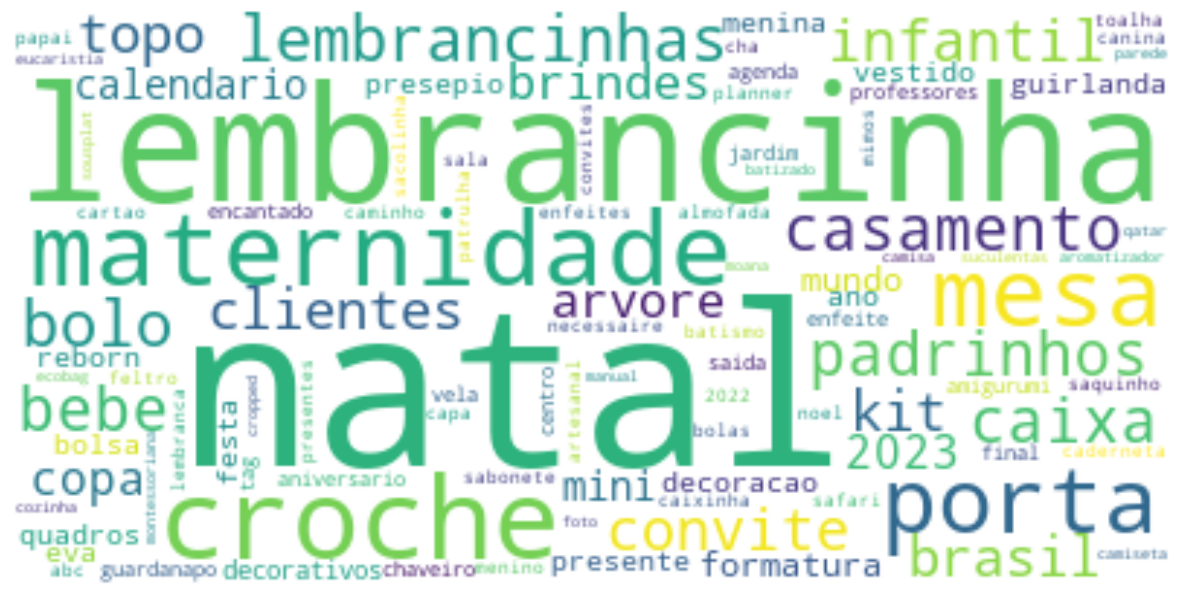

In [26]:
#queries
series = pd.Series(np.concatenate(df2_pairs['query_tokenized']))\
                                                    .value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

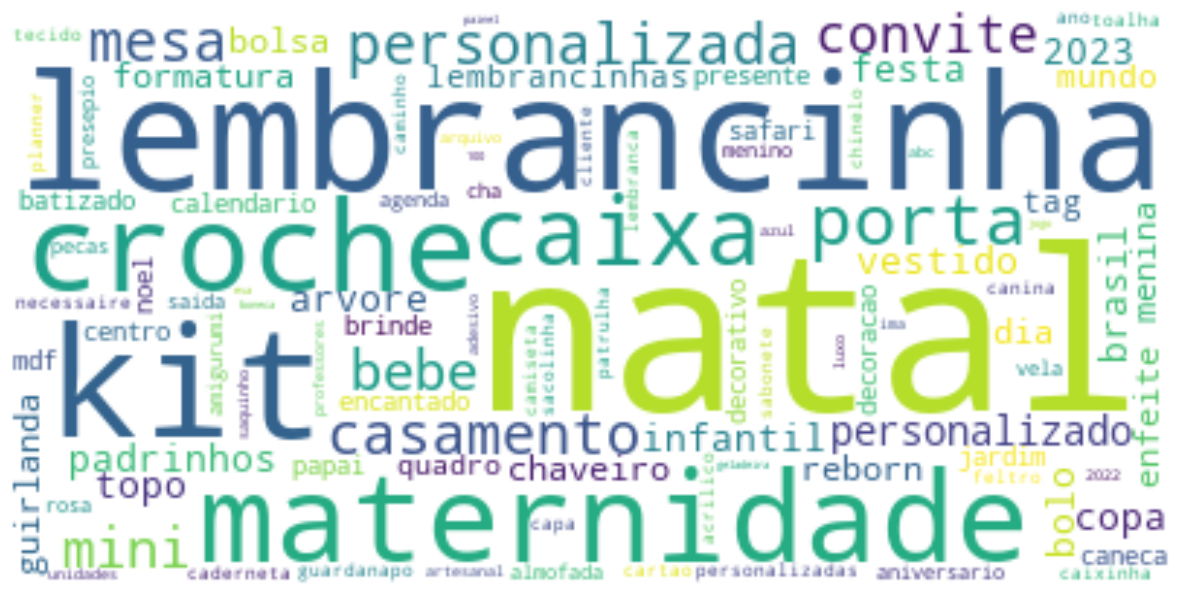

In [27]:
#tags
series = pd.Series(np.concatenate(df2_products['title_tokenized']))\
                                                    .value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 2. Construcao do indice: BM25 Indexing

Indexacao BM25 se baseia em dois principios:

* **TF or Term Frequency** — indica o numero de ocorrencias do termo no documento
* **IDF or Inverse Document Frequency** — mede o quao importante o termo é usando as estatisticas gerais dos documentos - atribui um peso a cada termo tokenizado, onde, termos frequentes recebem peso menor (considerados menos relevantes) e termos menos frequentes recebem um peso maior (considerados mais relevantes)

Alem disso, BM25 melhora TF-IDF em dois aspectos cruciais
* **diminui retornos para termos muito frequentes**. Assim, se a query estiver procurando por uma termo especifico que é extremamente comum no corpo de documentos (ex.: lembrancinha), entao o alto numero de ocorrencias desse termo vai deixar de util para a query.
* **considera o tamanho do documento no processo de match**. Assim, se um texto mais curto contem o mesmo numero de termos que dao match com a query do que um texto maior, entao o texto mais curto sera considerado como mais relevante.

Portanto, a funcao de relevancia se torna:

# $ \text{IDF}\,\times\, \frac{(k+1)\,\times\, \text{TF}}{\text{TF}+k \,\times\, (1-b+b \,\times \, \text{dl_adl})} $

onde $\text{dl_adl}$ é o comprimento do documento atual dividido pelo comprimento medio de todos os documentos. $k$ e $b$ sao *hiperparametros* introduzidos ao modelo tf-idf que serve para ajustar o impacto dos itens na funcao de rankeamento. Especificamente: $'k'$ ajusta o impacto de saturacao de termo e $'b$ ajusta o tamanho do documento.

<br>

Vale ressaltar que:
Nessa etapa, vou utilizar a biblioteca **rank_bm25** **apenas** para **criar indices**. Na etapa de ranking, eu mesma escreverei o algoritmo.


In [144]:
np.concatenate(df2_products['title_tokenized_bpe']).shape

(558746,)

In [148]:
flat_bpe_title = np.concatenate(df2_products['title_tokenized_bpe'])

In [149]:
 df2_products['title_tokenized_bpe'][:5]

0                                          [jogo, banheiro, croche, pe, ca]
1                                    [guardanapo, tecido, 1, 00, un, idade]
2                                                     [toalha, papai, noel]
3    [caix, ar, bis, feliz, natal, cliente, vo, ce, sem, pr, e, qu, er, er]
4                                           [arvore, natal, decor, ar, mdf]
Name: title_tokenized_bpe, dtype: object

In [151]:
for doc in df2_products['title_tokenized_bpe'][:20]:
    print(doc)

['jogo', 'banheiro', 'croche', 'pe', 'ca']
['guardanapo', 'tecido', '1', '00', 'un', 'idade']
['toalha', 'papai', 'noel']
['caix', 'ar', 'bis', 'feliz', 'natal', 'cliente', 'vo', 'ce', 'sem', 'pr', 'e', 'qu', 'er', 'er']
['arvore', 'natal', 'decor', 'ar', 'mdf']
['saquinho', 'maternidade', 'tag']
['caixa', 'presente']
['lembrancinha', 'r', 'sabonete', 'artesanal', 'mel', 'ab', 'el', 'hinha']
['caix', 'ar', 'cu', 'bo', 'lembranca', 'natal']
['lembrancinha', 'personali', 'z', 'ar']
['lo', 'cacao', 'mini', 'tab', 'le', 'rose', 'go', 'l', 'dr', 'rosa']
['tag', 'doce', 'natal']
['topo', 'bolo', 'menina', 'anjo', 'em', 'o', 'jardim']
['kit', 'centro', 'mesa', 'balao', 'mdf', 'personali', 'z', 'ar']
['bande', 'i', 'ro', 'la', 'decoracao', 'natal']
['agenda', 'di', 'ar', '2023']
['sacolinha', 'personali', 'z', 'ar', 'abc']
['mimo', 'cliente', 'calendario', 'bal', 'inha']
['mochil', 'inha', 'aniversario', 'festa', 'bu', 'bu', 'cor', 'u', 'j', 'inha']
['calendario', 'in', 'fin', 'ito', 'dis', 'p

In [ ]:
doc.count(word) / len(doc)

In [ ]:
docs_series = df2_products['title_tokenized_bpe']

In [ ]:
k1=1.5, b=0.75, epsilon=0.25

for 

In [ ]:
def tf(word, doc):
    return doc.count(word) / len(doc)

def n_containing(word, doclist):
    return sum(1 for doc in doclist if word in doc)

def idf(word, doclist):
    return math.log(len(doclist) / (0.01 + n_containing(word, doclist)))

def tfidf(word, doc, doclist):
    return (tf(word, doc) * idf(word, doclist))

In [ ]:

def _calc_idf(self, nd):
    """
    Calculates frequencies of terms in documents and in corpus.
    This algorithm sets a floor on the idf values to eps * average_idf
    """
    # collect idf sum to calculate an average idf for epsilon value
    idf_sum = 0
    # collect words with negative idf to set them a special epsilon value.
    # idf can be negative if word is contained in more than half of documents
    negative_idfs = []
    for word, freq in nd.items():
        idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
        self.idf[word] = idf
        idf_sum += idf
        if idf < 0:
            negative_idfs.append(word)
    self.average_idf = idf_sum / len(self.idf)

    eps = self.epsilon * self.average_idf
    for word in negative_idfs:
        self.idf[word] = eps

def get_scores(self, query):
    """
    The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
    this algorithm also adds a floor to the idf value of epsilon.
    See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
    :param query:
    :return:
    """
    score = np.zeros(self.corpus_size)
    doc_len = np.array(self.doc_len)
    for q in query:
        q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
        score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /
                                           (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
    return score

def get_batch_scores(self, query, doc_ids):
    """
    Calculate bm25 scores between query and subset of all docs
    """
    assert all(di < len(self.doc_freqs) for di in doc_ids)
    score = np.zeros(len(doc_ids))
    doc_len = np.array(self.doc_len)[doc_ids]
    for q in query:
        q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
        score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /
                                           (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
    return score.tolist()

In [136]:
#importar biblioteca para construir indices usando algoritmo bm25
from rank_bm25 import BM25Okapi

In [ ]:
k1=1.5, b=0.75, epsilon=0.25

In [139]:
bpe_products = df2_products[['title_tokenized_bpe', 'tags_tokenized_bpe',
       'category_tokenized_bpe']]

bpe_products

,title_tokenized_bpe,tags_tokenized_bpe,category_tokenized_bpe
0,"[jogo, banheiro, croche, pe, ca]","[jogo, banheiro, croche, tapete, decoracao, em, o, cor, chu, m, bo, ros, o, bebe]","[te, c, n, ica, artesanato]"
1,"[guardanapo, tecido, 1, 00, un, idade]","[guardanapo, tecido, gu, r, ad, ana, po, festa, even, to, ano, casamento, aniversario]",[casa]
2,"[toalha, papai, noel]","[natal, toalha, natal, toalha, mesa, papai, noel, faz, er, mao, croche, croche, tr]",[casa]
3,"[caix, ar, bis, feliz, natal, cliente, vo, ce, sem, pr, e, qu, er, er]","[lembranca, personali, z, ar, festa, caixa, caixinha, rose, go, l, d, fo, lha, fo, lha, gem, verde, branco, verde, branco, minnie, rosa, minnie, rosa, jardim, jardim, encan, tar, f, ado, mor, ena, f, ad, inha, p, j, mas, k, natal, ano, novo, feliz, natal, brinde, corporativo, car, d, bis, cartao, natal]",[lembrancinha]
4,"[arvore, natal, decor, ar, mdf]","[m, ada, jo, artesanato, decoracao, d, ena, tal, enfeite, d, ena, tal, arvore, d, ena, tal, decor, ada, em, m, d, fr]",[decoracao]
...,...,...,...
76706,"[sacolinha, lembrancinha]","[sacola, lembrancinha, lembrancinha, sacola, sacolinha, sacolinha, lembrancinha]","[bolsa, cartei, ra]"
76707,"[kit, pul, s, eiro, gravata, padrinho, verde, ti, f, fan, y]","[manual, padrinho, lembranca, madr, inho, madrinha, casamento, manual, casamento, madrinha, mimos, madrinha, m, y, r, amor, de, o, e, d, it, h, m, y, r, amor, pul, s, eiro, madrinha, casamento, 201, 8, casamento, 201, 9, pul, s, eira, per, o, la]",[casamento]
76708,"[vesti, r, noiv, o, princesa, novo]","[vestido, noiva, noiv, o, casamento, noiv, o, vesti, r, c, iv, il, noiv, inha, vesti, r, branco, noiv, ar, vesti, r, branco, vesti, r, princesa, vo, u, cas, ar, noiv, ar, noiv, as, r, io, vesti, r, noiv, o, barato, vesti, r, festa]",[roupa]
76709,"[papai, noel, amigurumi]","[presente, brinque, do, artesanato, artesanato, croche, infantil, decoracao, infantil, pel, u, cia, crianca, decoracao, bebe, boneco, papai, noel, ami, guru, m, er, papai, noel, noel, papai, noel, croche, natal, decoracao, natal]","[te, c, n, ica, artesanato]"


In [141]:
bm25_tags = BM25Okapi(bpe_products['tags_tokenized_bpe'])

In [192]:
all_words = pd.DataFrame(np.concatenate(df2_products['tags_tokenized']), columns=['words'])
all_words

,words
0,jogobanheiro
1,croche
2,tapete
3,decoracao
4,em o
...,...
2986082,topo
2986083,marsha
2986084,urso
2986085,marsha


In [193]:
unique_words = all_words.value_counts().reset_index()

unique_words.rename(columns={0: 'frequency'}, inplace=True)
unique_words

,words,frequency
0,personalizar,89868
1,natal,82355
2,lembrancinhar,75650
3,festa,70497
4,decoracao,43625
...,...,...
32639,geraldo,1
32640,gerai,1
32641,georgia,1
32642,georgepig,1


In [199]:
punctuations[-3]

'|'

In [204]:
tk = []
for word in unique_words['words']:
    if len(word)>2:
        for stpwrd in stop_words:
            for punct in punctuations:
                if stpwrd not in str(word) and punct not in str(word) and len(word)>2:
                    tk.append(str(word))

print(tk[-5:])

KeyboardInterrupt: 

In [203]:
'|' in  '||natalina'

True

In [197]:
np.where(np.array(tk)=='2')

(array([], dtype=int64),)

In [195]:
unique_words['words'] = unique_words['words'].str.normalize('NFKD')\
                                             .str.encode('ascii', errors='ignore')\
                                             .str.decode('utf-8')

In [196]:
unique_words

,words,frequency
0,personalizar,89868
1,natal,82355
2,lembrancinhar,75650
3,festa,70497
4,decoracao,43625
...,...,...
32639,geraldo,1
32640,gerai,1
32641,georgia,1
32642,georgepig,1


In [ ]:
def tf(word, doc):
    return doc.count(word) / len(doc)

def n_containing(word, doclist):
    return sum(1 for doc in doclist if word in doc)

def idf(word, doclist):
    return math.log(len(doclist) / (0.01 + n_containing(word, doclist)))

def tfidf(word, doc, doclist):
    return (tf(word, doc) * idf(word, doclist))


In [ ]:
# Create dictonary of words
# THIS ONE-TIME INDEXING IS THE MOST PROCESSOR-INTENSIVE 
#STEP AND WILL TAKE TIME TO RUN (BUT ONLY NEEDS TO BE RUN ONCE)
import re

plottest = plot_data[0][0:1000]

worddic = {}

for doc in plottest:
    for word in wordsunique:
        if word in doc:
            word = str(word)
            index = plottest.index(doc)
            positions = list(np.where(np.array(plottest[index]) == word)[0])
            idfs = tfidf(word,doc,plottest)
            try:
                worddic[word].append([index,positions,idfs])
            except:
                worddic[word] = []
                worddic[word].append([index,positions,idfs])

## Distribuicao estatistica dos termos
Vamos analisar a distribuicao estatistica dos termos relevantes e nao-relevantes.

Como o numero de documentos relevantes é desconhecido. Precisamos assumir que a probabilidade  the number of relevant documents is unknown, some
assumptions have to be made. Usually it is assumed that the
probability p is constant (e.g. equal to 0.5), and that q can be
estimated by the values from Inverse Document Frequency vector,
created as in the Vector Space Model

The principle takes into account that there is uncertainty in the representation of the information need and the documents. There can be a variety of sources of evidence that are used by the probabilistic retrieval methods, and the most common one is the statistical distribution of the terms in both the relevant and non-relevant documents.

# Sistema de recomendação: Content-Based Filtering
A recomendação é feita baseada nas **features de usuário** e nas **features dos produtos**. O match entre usuario e produto é feito pelo produto escalar:

## $ y^{i,j} = \vec{v}_{u}^{i}\cdot \vec{v}_{p}^{j}$

onde $\vec{v}_{u}^{i}$ e $\vec{v}_{p}^{j}$ são vetores computados das features do usuario $i$ e do produto $j$, respetivamente.

Muitos algoritmos de content-based filtering estimam $\vec{v}_{u}^{i}$ e  $\vec{v}_{p}^{j}$ usando redes neurais com a seguinte funcao de de custo:
## $J = \sum_{i,j}\left( \vec{v}_{u}^{i}\cdot \vec{v}_{p}^{j} -  y^{i,j} \right)^2 + \text{termos de regularização}$

Esse algoritmo tambem pode ser utilizado para *encontrar produtos similares*. Para isso, calculamos a distancia entre as features
## $ ||\vec{v}_{u}^{i} - \vec{v}_{p}^{j}||^2$

# Recomendação em grandes catálogos
O banco de dados contem mais de 6 milhoes de produtos. Portanto, o algoritmo pode ser computacionalmente inviavel de rodar para tantos itens. Para remediar esse problema, podemos implementar o sistema de recomendação em duas etapas: **retrieval** e **ranking**.

## Retrieval
Gerar uma lista de produtos plausiveis de serem buscados para aquela query. Por exemplo:
1) 100 produtos mais vendidos, clicados e adicionados ao carrinho numa determinada categoria de produtos
2) ....


Retrieving mais itens resulta numa performance melhor a custo de recomendacoes mais lentas. Para analizar o trade-off entre performance e velocidade, podemos rodar experimentos para ver se recuperar itens adicionais resulta em recomendacoes mais relevantes para o usuario.

## Ranking

Dada a lista de itens gerada na etapa anterior, rankeie os melhores produtos usando o modelo de aprendizagem e mostre esses itens rankeados ao usuario